In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantdisease


In [ ]:
import os
import shutil
import random
from tqdm import tqdm

# Paths
original_dataset_dir = '/kaggle/input/plantdisease/PlantVillage'
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create folders
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Set split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Go through each class folder and split
for class_name in tqdm(os.listdir(original_dataset_dir)):
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_count = int(train_ratio * total)
    val_count = int(val_ratio * total)

    # Paths for class subfolders
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Copy files
    for i, img in enumerate(images):
        src = os.path.join(class_path, img)
        if i < train_count:
            dst = os.path.join(train_dir, class_name, img)
        elif i < train_count + val_count:
            dst = os.path.join(val_dir, class_name, img)
        else:
            dst = os.path.join(test_dir, class_name, img)
        shutil.copy2(src, dst)


100%|██████████| 15/15 [02:30<00:00, 10.04s/it]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    "dataset/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    "dataset/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 11558 images belonging to 15 classes.
Found 2883 images belonging to 15 classes.


In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # freeze weights

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
EPOCHS = 10

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 186s 485ms/step - accuracy: 0.5525 - loss: 1.4270 - val_accuracy: 0.8401 - val_loss: 0.5021
Epoch 2/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 163s 449ms/step - accuracy: 0.8014 - loss: 0.5984 - val_accuracy: 0.8678 - val_loss: 0.3888
Epoch 3/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 163s 451ms/step - accuracy: 0.8364 - loss: 0.4912 - val_accuracy: 0.8793 - val_loss: 0.3544
Epoch 4/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 166s 458ms/step - accuracy: 0.8585 - loss: 0.4218 - val_accuracy: 0.8810 - val_loss: 0.3411
Epoch 5/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 163s 449ms/step - accuracy: 0.8602 - loss: 0.4078 - val_accuracy: 0.8817 - val_loss: 0.3379
Epoch 6/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 163s 451ms/step - accuracy: 0.8699 - loss: 0.3816 - val_accuracy: 0.8925 - val_loss: 0.3185
Epoch 7/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 166s 458ms/step - accuracy: 0.8754 - loss: 0.3666 - val_accuracy: 0.8900 - val_loss: 0.3102
Epoch 8/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 162s 448ms/step - accuracy: 0.8853 -

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 2076 images belonging to 15 classes.


In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.8955 - loss: 0.2993
Test Accuracy: 0.89


65/65 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.97      0.88      0.92       101
                     Pepper__bell___healthy       0.93      0.99      0.96       149
                      Potato___Early_blight       1.00      0.86      0.92       100
                       Potato___Late_blight       0.85      0.92      0.88       100
                           Potato___healthy       0.70      1.00      0.82        16
                      Tomato_Bacterial_spot       0.86      0.96      0.91       214
                        Tomato_Early_blight       0.94      0.48      0.64       100
                         Tomato_Late_blight       0.92      0.95      0.93       192
                           Tomato_Leaf_Mold       0.83      0.88      0.85        96
                  Tomato_Septoria_leaf_spot       0.76      0.91      0.83       178
Tomato_Spider_mites_Tw

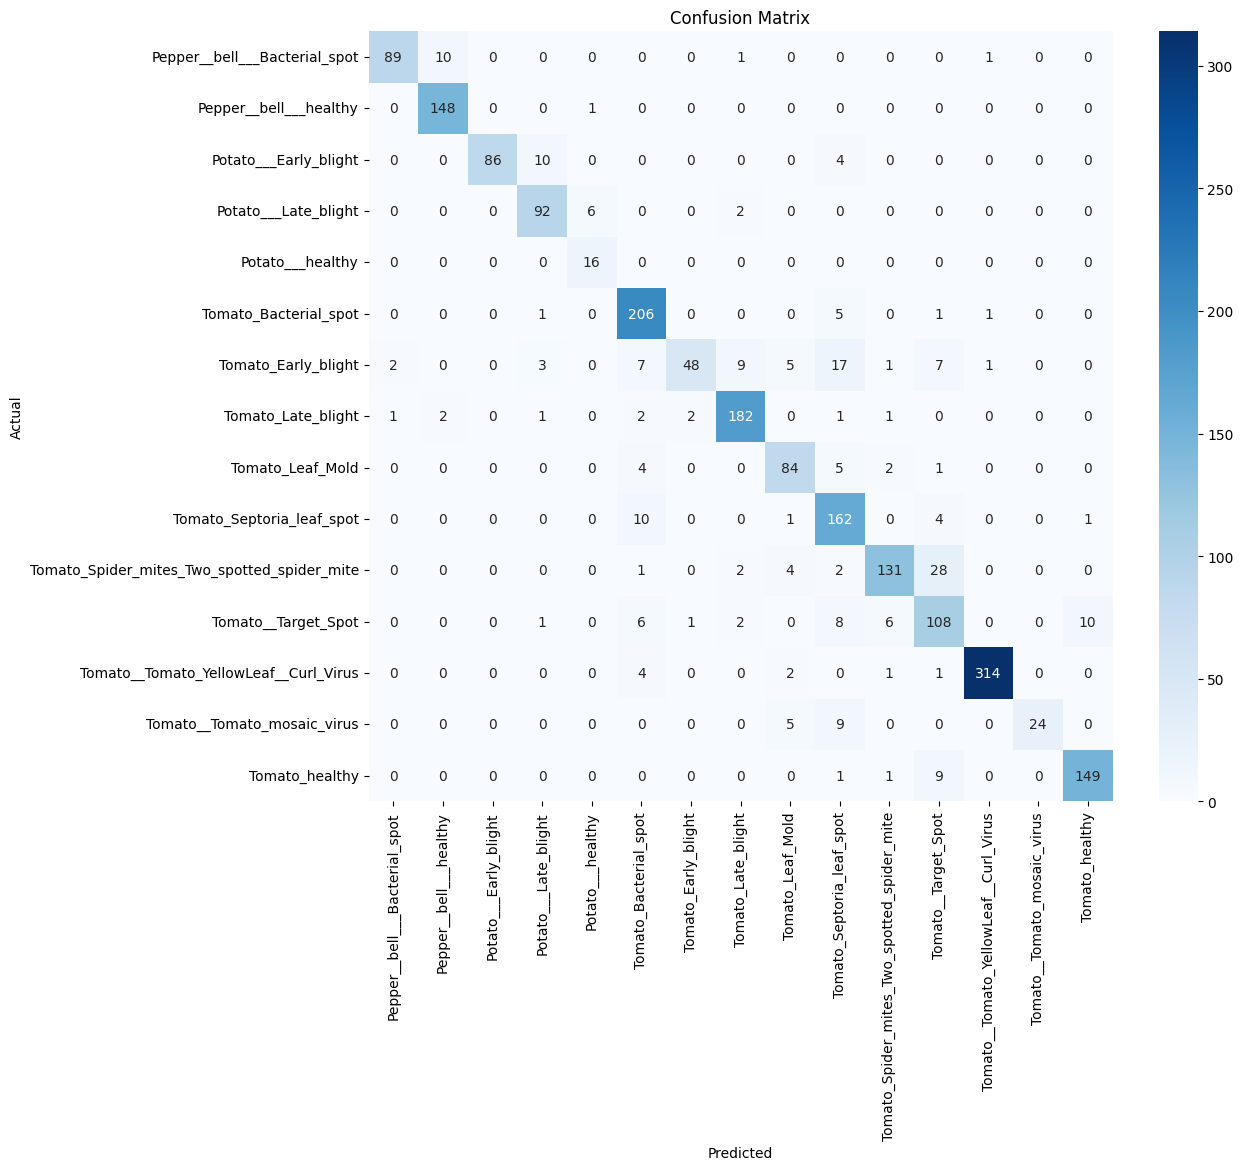

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class probabilities
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=class_labels, yticklabels=class_labels,
            annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [ ]:
model.save("plant_disease_model.h5")  # full model
# OR for TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp4htzbf9l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  139769171660432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139769171661584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139769171665040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139769171664656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139769171663504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139769171665232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139769171664272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139769171661200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139769171665424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139769171662928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139769171

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os


In [ ]:
model = tf.keras.models.load_model('plant_disease_model.h5')

In [ ]:
def predict_disease(img_path, model, class_names):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = img_array / 255.0  # Normalize to [0,1]

    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    predicted_class = class_names[predicted_index]

    return predicted_class, confidence


In [ ]:
# Example: class_names from training generator (make sure order is same!)
class_names = ['Pepper__bell___Bacterial_spot',
               'Pepper__bell___healthy',
               'Potato___Early_blight',
               'Potato___Late_blight',
               'Potato___healthy',
               'Tomato_Bacterial_spot',
               'Tomato_Early_blight',
               'Tomato_Late_blight',
               'Tomato_Leaf_Mold',
               'Tomato_Septoria_leaf_spot',
               'Tomato_Spider_mites_Two_spotted_spider_mite',
               'Tomato__Target_Spot',
               'Tomato__Tomato_YellowLeaf__Curl_Virus',
               'Tomato__Tomato_mosaic_virus',
               'Tomato_healthy']

image_path = '/content/dataset/test/Pepper__bell___Bacterial_spot/018e494e-d2eb-468b-9d02-40219d9f4921___JR_B.Spot 9045.JPG'  # Your test image

predicted_class, confidence = predict_disease(image_path, model, class_names)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: Pepper__bell___Bacterial_spot
Confidence: 0.94
